**KLASIFIKASI PREDIKSI KUALITAS ANGGUR DENGAN METODE RANDOM FOREST**

Berikut merupakan langkah langkah dalam melakukan klasifikasi dalam mempresiksi kualitas nggur dengan metode Random Forest.


**1. Langkah pertama : Persiapan dan eksplorasi data awal**

Persiapan dilakukan dengan memuat library dan memuat data_testing dan data_training pada dataframe.

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
try:
    df_train = pd.read_csv('/content/data_training.csv')
    df_test = pd.read_csv('/content/data_testing.csv')
    print("\nData Training dan Data Testing berhasil dimuat ke dalam program.")
except FileNotFoundError:
    print("\n[ERROR] File tidak ditemukan. Pastikan Anda sudah mengunggah 'data_training.csv' dan 'data_testing.csv' ke lingkungan Colab Anda.")


Data Training dan Data Testing berhasil dimuat ke dalam program.


**2. LANGKAH KEDUA : Mengidentifikasi kolom dan struktur data**

Dalam tahap ini ditunjukan data yang telah dimasukkan ke dataframe serta diindentifikasi kolom kolom utama pada data_testing dan data_training seperti:
1. Kolom Target: 'quality' (Nilai yang ingin diprediksi)
2. Kolom ID: 'Id' (Penanda unik, harus dipisahkan saat pemodelan, tapi dipakai untuk hasil akhir)
3. Kolom Fitur: Semua kolom lain (misalnya 'fixed acidity', 'alcohol', dll.)

In [2]:
print("\n=======================================================")
print("           STRUKTUR DATA TRAINING (df_train)")
print("=======================================================")

print("\n[Preview Data Training (5 Baris Awal)]")
print(df_train.head())

print("\n[Informasi Kolom Data Training]")
df_train.info()

print("\n=======================================================")
print("           STRUKTUR DATA TESTING (df_test)")
print("=======================================================")

print("\n[Preview Data Testing (5 Baris Awal)]")
print(df_test.head())

print("\n[Informasi Kolom Data Testing]")
df_test.info()

test_ids = df_test['Id']
print(f"\nJumlah sampel pada data training: {len(df_train)}")
print(f"Jumlah sampel pada data testing: {len(df_test)}")


           STRUKTUR DATA TRAINING (df_train)

[Preview Data Training (5 Baris Awal)]
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.3             0.740         0.08             1.7      0.094   
1            8.1             0.575         0.22             2.1      0.077   
2           10.1             0.430         0.40             2.6      0.092   
3           12.9             0.500         0.55             2.8      0.072   
4            8.4             0.360         0.32             2.2      0.081   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 10.0                  45.0  0.99576  3.24       0.50   
1                 12.0                  65.0  0.99670  3.29       0.51   
2                 13.0                  52.0  0.99834  3.22       0.64   
3                  7.0                  24.0  1.00012  3.09       0.68   
4                 32.0                  79.0  0.99640  3.30       0.72   



**3. LANGKAH 3 : Pemisahan fitur dan target**

memisahkan data menjadi tiga bagian utama. Dengan membuang kolom yang tidak relevan untuk pelatihan model (Id dan quality untuk fitur) dan menyimpan data yang akan digunakan:

1. X_train: Berisi Fitur (semua variabel kimiawi) dari data latih—ini adalah "petunjuk" yang akan dipelajari model.
2. y_train: Berisi Target (quality) dari data latih—ini adalah "jawaban" yang harus diprediksi model.
3. X_test: Berisi Fitur dari data uji, siap untuk diprediksi.
4. test_ids: Kolom Id dari data uji disimpan terpisah.

In [3]:
X_train = df_train.drop(['quality', 'Id'], axis=1)
y_train = df_train['quality']
X_test = df_test.drop('Id', axis=1)
test_ids = df_test['Id']

print("Data berhasil dipisahkan menjadi X_train, y_train, dan X_test.")
print(f"Bentuk X_train: {X_train.shape}, Bentuk y_train: {y_train.shape}")

Data berhasil dipisahkan menjadi X_train, y_train, dan X_test.
Bentuk X_train: (857, 11), Bentuk y_train: (857,)


**4. LANGKAH 4 : Penanganan Missing Value**

Tahap ini bertujuan untuk mengisi atau menangani nilai yang hilang (Missing Values atau NaN) yang mungkin ada di data fitur (X). Nilai yang hilang dapat menyebabkan model error atau menghasilkan prediksi yang buruk.

Dengan menggunakan strategi median. Strategi ini dipilih karena median lebih tahan terhadap outlier, memastikan data isian lebih stabil.Maka pada tahap ini hanya melatih (fit) imputer pada data training, dan kemudian hasil pembelajaran tersebut saya terapkan (transform) pada kedua dataset (X_train dan X_test), memastikan tidak ada kebocoran informasi dari data testing ke data training.


In [4]:
print("\n--- Pengecekan Missing Values Awal ---")
print("Missing values di Data Training:", X_train.isnull().sum().sum())
print("Missing values di Data Testing:", X_test.isnull().sum().sum())

if X_train.isnull().sum().sum() > 0 or X_test.isnull().sum().sum() > 0:
    print("\n⚠️ Ditemukan Missing Values. Melakukan Imputasi...")

    imputer = SimpleImputer(strategy='median')
    imputer.fit(X_train)

    X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

    print("✅ Imputasi selesai.")

    X_train = X_train_imputed
    X_test = X_test_imputed
else:
    print("\n✅ Tidak ditemukan Missing Values. Lanjut ke tahap berikutnya.")

print("Total missing values di X_train setelah Imputasi:", X_train.isnull().sum().sum())
print("Total missing values di X_test setelah Imputasi:", X_test.isnull().sum().sum())


--- Pengecekan Missing Values Awal ---
Missing values di Data Training: 0
Missing values di Data Testing: 0

✅ Tidak ditemukan Missing Values. Lanjut ke tahap berikutnya.
Total missing values di X_train setelah Imputasi: 0
Total missing values di X_test setelah Imputasi: 0


**5. LANGKAH 5 : Feature Scaling (Standarisasi)**

Langkah ini merupakan proses mengubah nilai numerik dari fitur-fitur data Anda ke dalam rentang standar, tanpa mengubah perbedaan mendasar dalam distribusi datanya.

Scaling memastikan bahwa variabel seperti chlorides (yang nilainya kecil, misal 0.05) tidak "kalah suara" dari variabel seperti total sulfur dioxide (yang nilainya besar, misal 200.0) di mata algoritma.

In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Standardisasi (Feature Scaling) telah selesai.")
print("X_train dan X_test sekarang siap untuk melatih model. ✨")


✅ Standardisasi (Feature Scaling) telah selesai.
X_train dan X_test sekarang siap untuk melatih model. ✨


**6. LANGKAH 6 : Pelatihan model Random Forest**

Langkah ini merupakan langkah salah satu langkah utama, yaitu melakukan pelatihan model menggunakan data training yang yang telah diinput di  dataframe.

In [6]:
rf_model = RandomForestClassifier(random_state=42)

print("Memulai pelatihan model Random Forest dasar...")

rf_model.fit(X_train_scaled, y_train)

print("✅ Pelatihan model Random Forest dasar selesai!")

Memulai pelatihan model Random Forest dasar...
✅ Pelatihan model Random Forest dasar selesai!


**7. LANGKAH 7 : Penyempurnaan Model dengan Grid Search**

Langkah ini merupakan langkah penyempurnaan medol menggunakan Grid Search untuk menyempurnakan model Random Forest yang telah dilakukan.

In [15]:
param_grid = {

    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10]
}

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train_scaled, y_train)
best_rf_model = grid_search.best_estimator_

print("\n--- Hasil Tuning ---")
print(f"🎉 Parameter Terbaik Ditemukan: {grid_search.best_params_}")
print(f"Skor Akurasi Terbaik (Cross-Validation): {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits

--- Hasil Tuning ---
🎉 Parameter Terbaik Ditemukan: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}
Skor Akurasi Terbaik (Cross-Validation): 0.6522


**8. LANGKAH 8 : Evaluasi model terbaik**

Langkah ini dilakukan evalusi model terbaik dengan melakukan prediksi pada data training.

In [8]:
y_train_pred = best_rf_model.predict(X_train_scaled)

print("\n--- Laporan Klasifikasi pada Data Training ---")
print(classification_report(y_train, y_train_pred))



--- Laporan Klasifikasi pada Data Training ---
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00       362
           6       0.99      1.00      1.00       341
           7       1.00      0.99      1.00       109
           8       1.00      1.00      1.00        13

    accuracy                           1.00       857
   macro avg       1.00      1.00      1.00       857
weighted avg       1.00      1.00      1.00       857



**9. LANGKAH 9 : Evaluasi akhir model**

Langkah ini merupakan langkah akhir dalam evaluasi model pada data training dengan melakukan:

1. Prediksi data training.
2. Analisis klasifikasi.
3. Analisis confusion matrix.

Kemudian dilakukan visualisasi confusion matrix yang telah diperoleh.

--- Hasil Tuning Terbaik ---
Parameter Terbaik Ditemukan: {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}
Skor Akurasi Terbaik (Cross-Validation): 0.6522

--- Laporan Klasifikasi pada Data Training (Menggunakan Model Terbaik) ---
              precision    recall  f1-score   support

           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00       362
           6       0.99      1.00      1.00       341
           7       1.00      0.99      1.00       109
           8       1.00      1.00      1.00        13

    accuracy                           1.00       857
   macro avg       1.00      1.00      1.00       857
weighted avg       1.00      1.00      1.00       857


--- Confusion Matrix Data Training ---


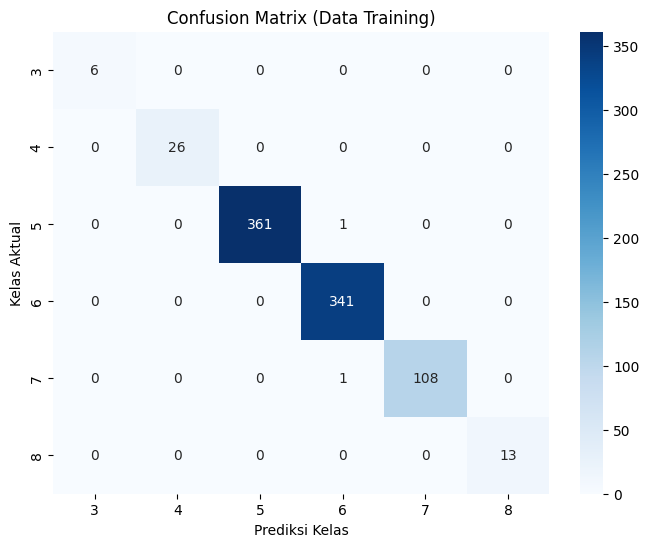

✅ Evaluasi model terbaik selesai. Model siap digunakan untuk prediksi data testing.


In [9]:
print("--- Hasil Tuning Terbaik ---")
print(f"Parameter Terbaik Ditemukan: {grid_search.best_params_}")
print(f"Skor Akurasi Terbaik (Cross-Validation): {grid_search.best_score_:.4f}")

y_train_pred = best_rf_model.predict(X_train_scaled)
print("\n--- Laporan Klasifikasi pada Data Training (Menggunakan Model Terbaik) ---")
print(classification_report(y_train, y_train_pred, zero_division=0))
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_train, y_train_pred)

print("\n--- Confusion Matrix Data Training ---")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_train),
            yticklabels=np.unique(y_train))
plt.title('Confusion Matrix (Data Training)')
plt.xlabel('Prediksi Kelas')
plt.ylabel('Kelas Aktual')
plt.show()

print("✅ Evaluasi model terbaik selesai. Model siap digunakan untuk prediksi data testing.")

**10. LANGKAH 10 : Tahap Akhir**

Langkah ini merupakan langkah terakhir dalam klasifikasi dengan metode Random Forest dengan uning menggunakan Grid Search.

berikut langkah akhir yang dilakukan:
1. melakukan prediksi data testing (deployment).
2. pembuatan submission file.
3. penyimpanan csv akhir.

In [10]:
print("Memulai prediksi kualitas anggur pada data testing...")

predictions = best_rf_model.predict(X_test_scaled)

print("✅ Prediksi selesai! Hasil prediksi adalah array numpy.")
print(f"Bentuk hasil prediksi: {predictions.shape}")

Memulai prediksi kualitas anggur pada data testing...
✅ Prediksi selesai! Hasil prediksi adalah array numpy.
Bentuk hasil prediksi: (286,)


In [11]:
df_submission = pd.DataFrame({
    'Id': test_ids,
    'quality': predictions
})

df_submission['quality'] = df_submission['quality'].astype(int)

print("\n--- Preview File Submission ---")
print(df_submission.head())
print(f"Total baris submission: {len(df_submission)}")


--- Preview File Submission ---
     Id  quality
0   222        5
1  1514        6
2   417        5
3   754        5
4   516        5
Total baris submission: 286


In [12]:
nama_file_submission = 'hasilprediksi_058.csv'
df_submission.to_csv(nama_file_submission, index=False)

print(f"\n--- Selesai Total! ---")
print(f"Hasil prediksi Anda berhasil disimpan ke '{nama_file_submission}'.")
print("\nSekarang Anda bisa mengunduh file ini dari sesi Colab Anda dan mengumpulkannya bersama link GitHub!")


--- Selesai Total! ---
Hasil prediksi Anda berhasil disimpan ke 'hasilprediksi_058.csv'.

Sekarang Anda bisa mengunduh file ini dari sesi Colab Anda dan mengumpulkannya bersama link GitHub!
